In [2]:
### loading data        V
#   inspection          V
#   training / validation split
#   model tuning
#   augmentation
#     generator / brightness / perspective / shadow
#   flipping
import pandas as pd
import scipy.misc
import random
import numpy as np
import cv2
import time

#read data.txt
driving_log=pd.read_csv('./data/driving_log.csv').sample(frac=1.0)
df_no_zero = driving_log[driving_log.steering != 0]
df_zero = driving_log[driving_log.steering == 0]

print(df_no_zero.size)
print(df_zero.size)
df = df_no_zero.append(df_zero.sample(frac=0.1))
print(df.size)

25725
30527
28777


In [3]:
#get number of images
num_images = len(df)

#split train/validation data set
msk = np.random.rand(num_images) < 0.8
train = df[msk]
valid = df[~msk]

print('total number: {}, reserved for training: {}, validation: {}'.format(num_images, len(train), len(valid)))

def LoadTrainBatch(batch_size):
    x_out = []
    y_out = []
    batch = train.sample(batch_size).as_matrix()
    
    i = 0
    for row in batch:
        x_out.append(cv2.resize(scipy.misc.imread('./data/' + row[0].strip()), (96,48)) / 255 -0.5)
        y_out.append(row[3])
        i += 1
    return np.array(x_out), np.array(y_out)

def LoadValBatch(batch_size):
    x_out = []
    y_out = []
    batch = valid.sample(batch_size).as_matrix()
    for row in batch:
        x_out.append(cv2.resize(scipy.misc.imread('./data/' + row[0].strip()), (96,48)) / 255 -0.5)
        y_out.append(row[3])
    return np.array(x_out), np.array(y_out)

xCenter_train, y_train = LoadTrainBatch(len(train))
xCenter_valid, y_valid = LoadTrainBatch(len(valid))

total number: 4111, reserved for training: 3293, validation: 818


In [ ]:
def histogramNormalized(img):
    return cv2.equalizeHist(img)

def meanCentralized(X_train, X_valid):
    image_Mean_Train = np.mean(X_train)
    image_Mean_Valid = np.mean(X_valid)

    X_train = (X_train - np.tile(image_Mean_Train, (160,320))) / 180
    X_valid = (X_valid - np.tile(image_Mean_Valid, (160,320))) / 180
    return X_train, X_valid

def histogramNormalizeAll(X_train, X_valid):
    for img in X_train:
        img = histogramNormalized(img)
    for img in X_valid:
        img = histogramNormalized(img)    
        
histogramNormalizeAll(xCenter_train, xCenter_valid)

print('before mean normalization, {:.3f}'.format(np.mean(xCenter_train)))
X_train_grayscale, X_test_grayscale, X_valid_grayscale = meanCentralized(X_train_grayscale, X_valid_grayscale)
print('after mean normalization, {:.3f}'.format(np.mean(X_train_grayscale)))

In [4]:
from keras.layers.core import Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 96, 3))
for layer in base_model.layers:
    layer.trainable = False
    
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024)(x)
prediction = Dense(1, name='prediction')(x)

model = Model(input=base_model.input, output=prediction)

model.compile(loss='mse',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 48, 96, 3)     0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 48, 96, 64)    1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 48, 96, 64)    36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 24, 48, 64)    0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [9]:
from keras.callbacks import EarlyStopping
epochs = 50
batch_size = 374

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

model.fit(xCenter_train, y_train, batch_size=batch_size, callbacks=[early_stopping], nb_epoch=epochs, verbose=1, validation_data=(xCenter_valid,y_valid), shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0)


Train on 3293 samples, validate on 818 samples
Epoch 1/50
3293/3293 [==============================] - 10s - loss: 0.0083 - acc: 0.1048 - val_loss: 0.0071 - val_acc: 0.1064
Epoch 2/50
3293/3293 [==============================] - 4s - loss: 0.0081 - acc: 0.1048 - val_loss: 0.0067 - val_acc: 0.1064

In [10]:
model.save('model.h5')

In [4]:
### training
#   batch_size / epochs
#   Tensorboard

import os

CHECK_POINT_DIR = './save'
if not os.path.exists(CHECK_POINT_DIR):
    os.makedirs(CHECK_POINT_DIR)

checkpoint_path = os.path.join(CHECK_POINT_DIR, "model.h5")

epochs = 10
batch_size = 100

# train over the dataset about 30 times
for epoch in range(epochs):
    model.fit()
    for i in range(int(num_images/batch_size)):
        xs, ys = LoadTrainBatch(batch_size)
        train_step.run(feed_dict={x: xs, y_: ys, keep_prob: 0.8})
        if i % 10 == 0:
            loss_value_train = rmse.eval(feed_dict={x:xs, y_: ys, keep_prob: 1.0})
            xs_valid, ys_valid = LoadValBatch(batch_size)
            loss_value_valid = rmse.eval(feed_dict={x:xs_valid, y_: ys_valid, keep_prob: 1.0})
            print("Epoch: %d, Step: %d, training loss: %g, validation loss: %g" % (epoch, epoch * batch_size + i, loss_value_train, loss_value_valid))
            if epoch * batch_size > 600:
                if loss_value_valid < best:
                    performance_decay = 0
                    best = loss_value_valid
                    filename = saver.save(sess, checkpoint_path)
                    print("Best model saved in file: %s" % filename)
                else:
                    performance_decay += 1
                    if performance_decay == early_stopping_tolerance:
                        Print("Performance not improving over %d steps, stopping." %(early_stopping_tolerance))
                        break
        # write logs at every iteration
        summary = merged_summary_op.eval(feed_dict={x:xs, y_: ys, keep_prob: 1.0})
        summary_writer.add_summary(summary, epoch * batch_size + i)

NameError: name 'keras' is not defined

4 Steering angle between -1.1 and -0.9
./data/IMG/left_2016_12_01_13_38_26_805.jpg


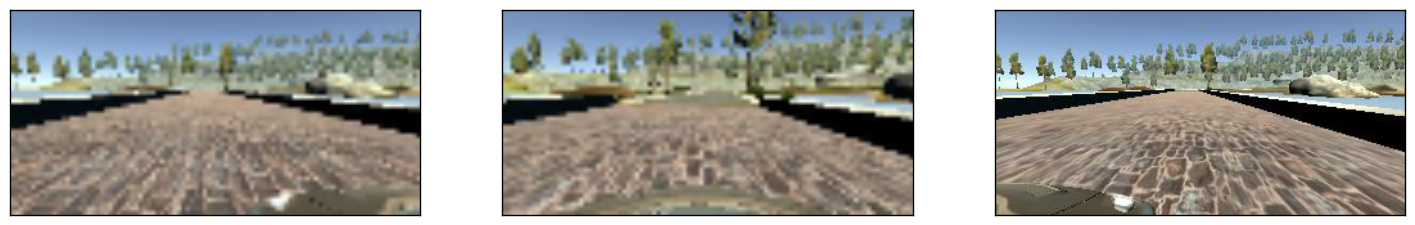

3 Steering angle between -0.9 and -0.7
./data/IMG/left_2016_12_01_13_38_26_704.jpg


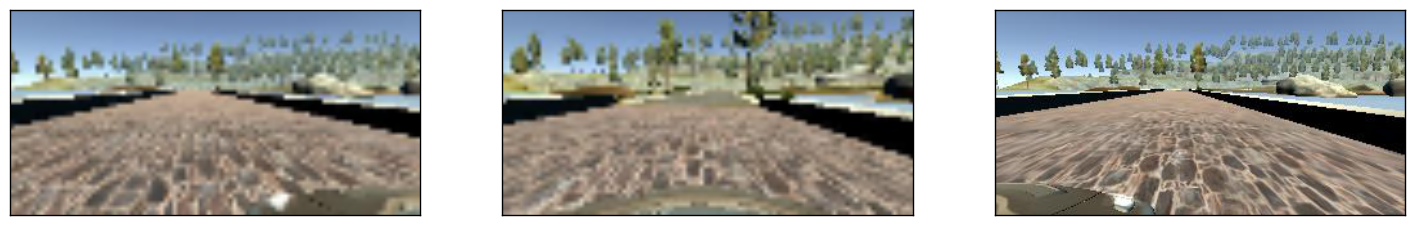

17 Steering angle between -0.7 and -0.5
./data/IMG/left_2016_12_01_13_39_59_195.jpg


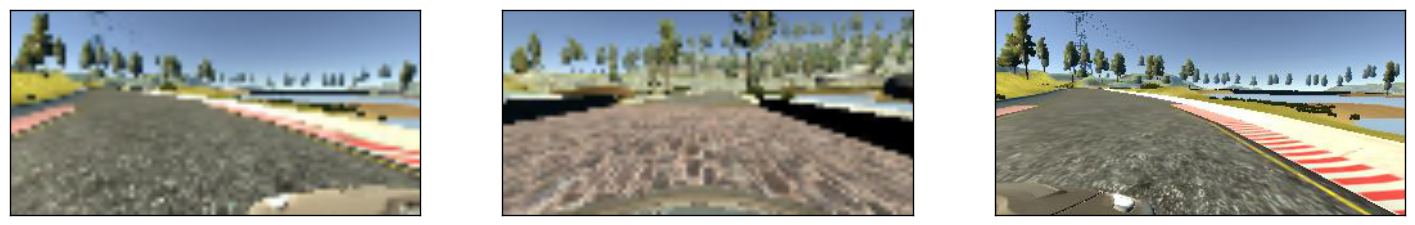

140 Steering angle between -0.5 and -0.3
./data/IMG/left_2016_12_01_13_45_29_420.jpg


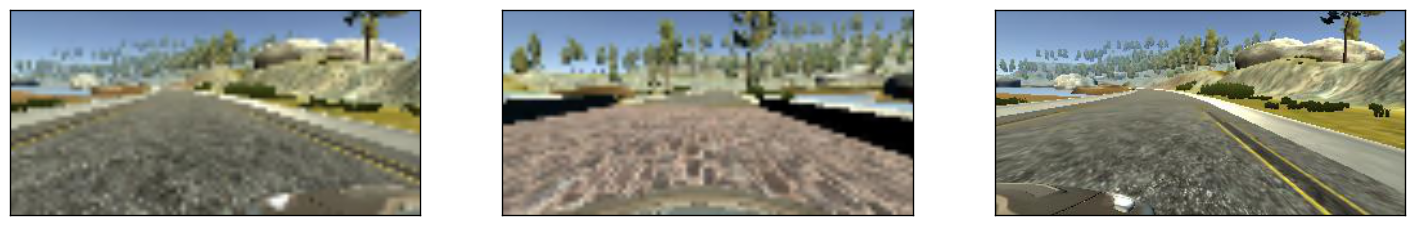

773 Steering angle between -0.3 and -0.1
./data/IMG/left_2016_12_01_13_44_07_398.jpg


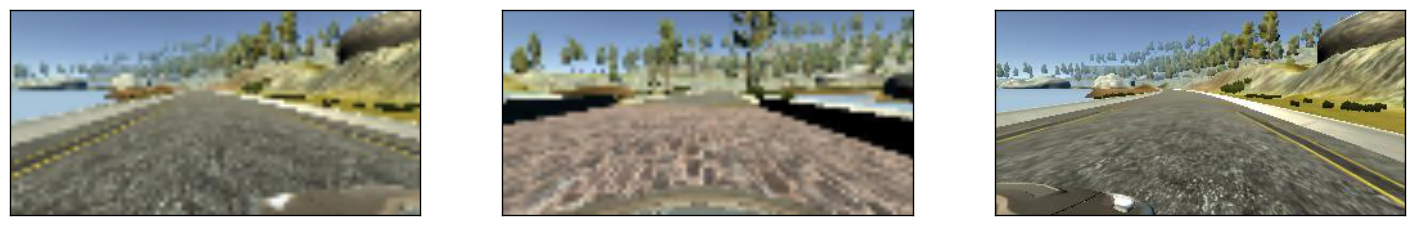

5923 Steering angle between -0.1 and 0.1
./data/IMG/left_2016_12_01_13_36_15_758.jpg


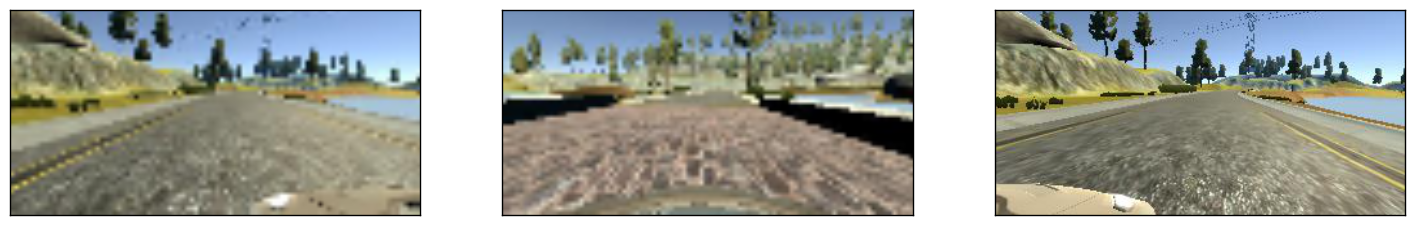

942 Steering angle between 0.1 and 0.3
./data/IMG/left_2016_12_01_13_37_19_512.jpg


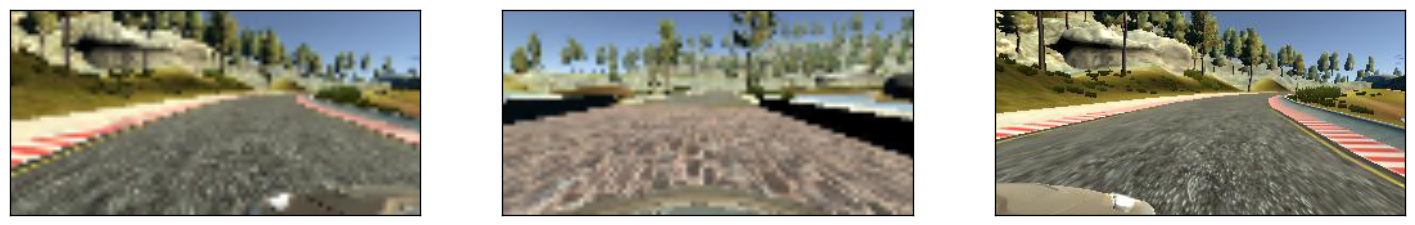

214 Steering angle between 0.3 and 0.5
./data/IMG/left_2016_12_01_13_43_42_119.jpg


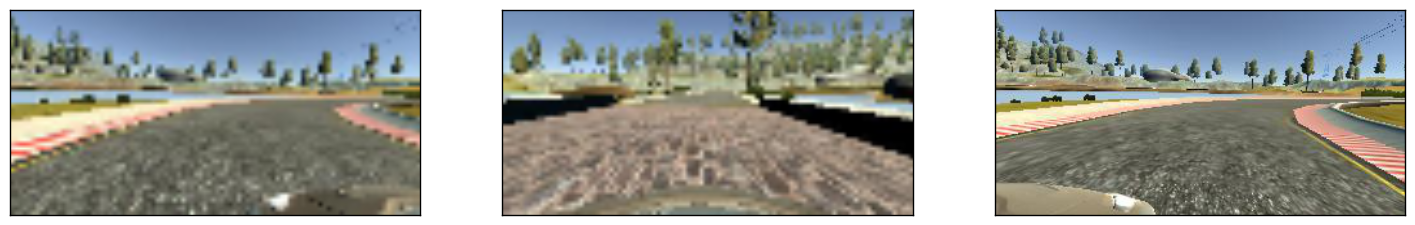

17 Steering angle between 0.5 and 0.7
./data/IMG/left_2016_12_01_13_38_26_299.jpg


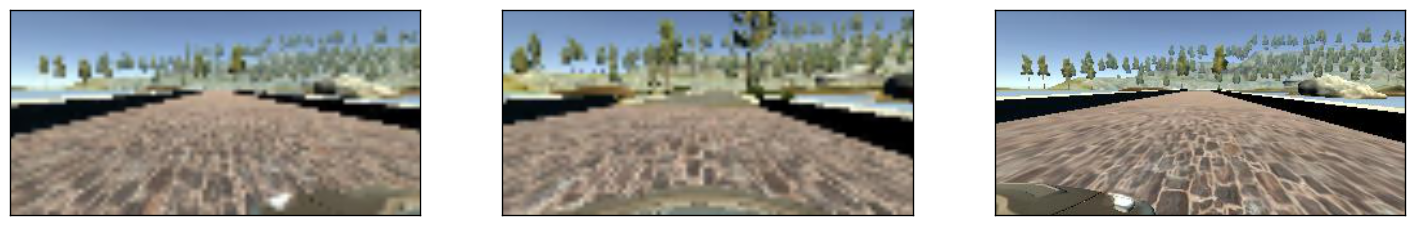

1 Steering angle between 0.7 and 0.9
./data/IMG/left_2016_12_01_13_38_59_461.jpg


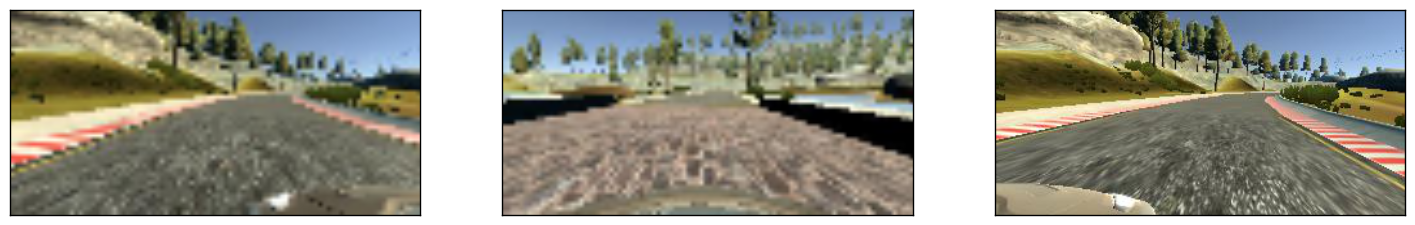

2 Steering angle between 0.9 and 1.1
./data/IMG/left_2016_12_01_13_38_42_894.jpg


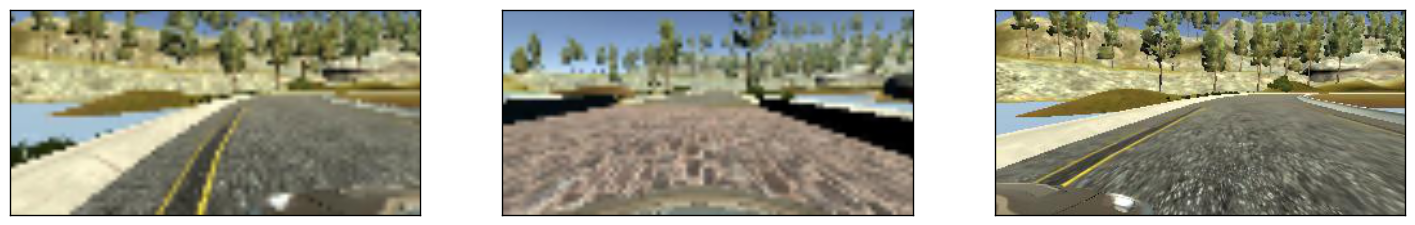

0 Steering angle between 1.1 and 1.3
./data/IMG/left_2016_12_01_13_38_42_894.jpg


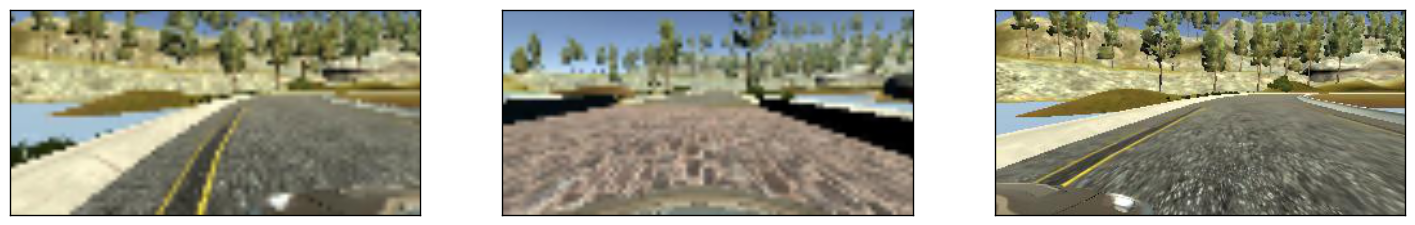

In [4]:


def frange(start, end, step):
    while start < end:
        yield start
        start += step
        
def plotImagesPerClass():
    pltChangeSize()
    step = 0.2
    classes = frange(-1.1, 1.1, step)

    for cls in classes:
        fig, axes = plt.subplots(ncols=3, figsize=(18, 4))
        ceil = cls + step
        subset = driving_log.loc[(driving_log['steering'] >= cls) & (driving_log['steering'] < ceil)]
        print("{} Steering angle between {:.1f} and {:.1f}".format(len(subset), cls, ceil))
        
        if len(subset)>0:
            idx = subset.sample(1)
            
        axes[0].set_xticks([])
        axes[0].set_yticks([])
        print('./data/' + idx['left'].iloc[0].strip())
        axes[0].imshow(cv2.resize(scipy.misc.imread('./data/' + idx['left'].iloc[0].strip()),(96,48)))

        axes[1].set_xticks([])
        axes[1].set_yticks([])
        axes[1].imshow(scipy.misc.imread('./data/' + idx['center'].iloc[0].strip()))

        axes[2].set_xticks([])
        axes[2].set_yticks([])
        axes[2].imshow(scipy.misc.imread('./data/' + idx['right'].iloc[0].strip()))


        plt.show()
            

    
plotImagesPerClass()

In [3]:
driving_log.describe()


steering     throttle        brake        speed
count  8036.000000  8036.000000  8036.000000  8036.000000
mean      0.004070     0.869660     0.001970    28.169839
std       0.128840     0.301326     0.036565     6.149327
min      -0.942695     0.000000     0.000000     0.502490
25%       0.000000     0.985533     0.000000    30.183093
50%       0.000000     0.985533     0.000000    30.186400
75%       0.000000     0.985533     0.000000    30.186640
max       1.000000     0.985533     1.000000    30.709360

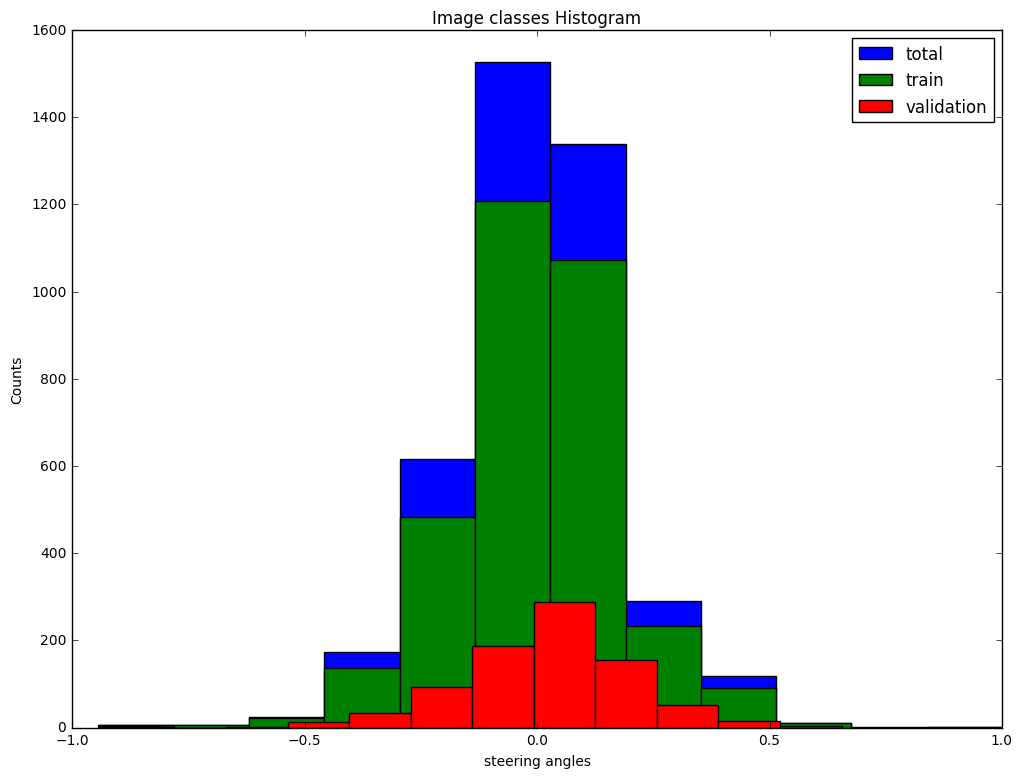

In [21]:
### inspection
import matplotlib.pyplot as plt
%matplotlib inline
def inspectHistogram():
    pltChangeSize()
    
    plt.hist(df.steering, bins=12, label='total')
    plt.hist(y_train, bins=12, label='train')
    plt.hist(y_valid, bins=12, label='validation')

    plt.title('Image classes Histogram')  
    plt.xlabel('steering angles')  
    plt.ylabel('Counts')  
    plt.legend()  

def pltChangeSize():
    fig_size = plt.rcParams["figure.figsize"]
    # Set figure width to 12 and height to 9
    fig_size[0] = 12
    fig_size[1] = 9
    plt.rcParams["figure.figsize"] = fig_size

inspectHistogram()

In [3]:
### model, forked from NVidia AutoPilot model
#   active functions
#   layers
#   dropout

from tensorflow.contrib.layers import flatten
import tensorflow as tf
import scipy

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W, stride):
    return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='VALID')

x = tf.placeholder(tf.float32, shape=[None, 160, 320, 3])
y_ = tf.placeholder(tf.float32, shape=[None, 1])

x_image = x

#first convolutional layer
W_conv1 = weight_variable([5, 5, 3, 24])
b_conv1 = bias_variable([24])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, 2) + b_conv1)

#second convolutional layer
W_conv2 = weight_variable([5, 5, 24, 36])
b_conv2 = bias_variable([36])

h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2, 2) + b_conv2)

#third convolutional layer
W_conv3 = weight_variable([5, 5, 36, 48])
b_conv3 = bias_variable([48])

h_conv3 = tf.nn.relu(conv2d(h_conv2, W_conv3, 2) + b_conv3)

#fourth convolutional layer
W_conv4 = weight_variable([3, 3, 48, 64])
b_conv4 = bias_variable([64])

h_conv4 = tf.nn.relu(conv2d(h_conv3, W_conv4, 1) + b_conv4)

#fifth convolutional layer
W_conv5 = weight_variable([3, 3, 64, 64])
b_conv5 = bias_variable([64])

h_conv5 = tf.nn.relu(conv2d(h_conv4, W_conv5, 1) + b_conv5)

#FCL 1
W_fc1 = weight_variable([27456, 1164])
b_fc1 = bias_variable([1164])

h_conv5_flat = flatten(h_conv5)

h_fc1 = tf.nn.relu(tf.matmul(h_conv5_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#FCL 2
W_fc2 = weight_variable([1164, 100])
b_fc2 = bias_variable([100])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

#FCL 3
W_fc3 = weight_variable([100, 50])
b_fc3 = bias_variable([50])

h_fc3 = tf.nn.relu(tf.matmul(h_fc2_drop, W_fc3) + b_fc3)

h_fc3_drop = tf.nn.dropout(h_fc3, keep_prob)

#FCL 3
W_fc4 = weight_variable([50, 10])
b_fc4 = bias_variable([10])

h_fc4 = tf.nn.relu(tf.matmul(h_fc3_drop, W_fc4) + b_fc4)

h_fc4_drop = tf.nn.dropout(h_fc4, keep_prob)

#Output
W_fc5 = weight_variable([10, 1])
b_fc5 = bias_variable([1])

y = tf.mul(tf.tanh(tf.matmul(h_fc4_drop, W_fc5) + b_fc5), 2) #scale the atan output



In [18]:
df

center  \
6041  IMG/center_2016_12_01_13_43_19_465.jpg   
4847  IMG/center_2016_12_01_13_41_18_431.jpg   
1115  IMG/center_2016_12_01_13_34_31_251.jpg   
6463  IMG/center_2016_12_01_13_44_02_331.jpg   
1717  IMG/center_2016_12_01_13_35_32_343.jpg   
6924  IMG/center_2016_12_01_13_44_49_014.jpg   
4977  IMG/center_2016_12_01_13_41_31_606.jpg   
1439  IMG/center_2016_12_01_13_35_04_080.jpg   
2447  IMG/center_2016_12_01_13_36_46_300.jpg   
2259  IMG/center_2016_12_01_13_36_27_209.jpg   
5376  IMG/center_2016_12_01_13_42_12_064.jpg   
6985  IMG/center_2016_12_01_13_44_55_235.jpg   
7162  IMG/center_2016_12_01_13_45_13_219.jpg   
4353  IMG/center_2016_12_01_13_39_59_498.jpg   
2987  IMG/center_2016_12_01_13_37_40_955.jpg   
3905  IMG/center_2016_12_01_13_39_14_069.jpg   
868   IMG/center_2016_12_01_13_34_06_252.jpg   
578   IMG/center_2016_12_01_13_33_36_803.jpg   
6758  IMG/center_2016_12_01_13_44_32_214.jpg   
5268  IMG/center_2016_12_01_13_42_01_078.jpg   
666   IMG/center_2016_12_01_13_33_45_731.jpg   
7756  IMG/center_2016_12_01_13_46_13_401.jpg   
7599  IMG/center_2016_12_01_13_45_57_492.jpg   
3651  IMG/center_2016_12_01_13_38_48_278.jpg   
2279  IMG/center_2016_12_01_13_36_29_248.jpg   
1991  IMG/center_2016_12_01_13_36_00_077.jpg   
3325  IMG/center_2016_12_01_13_38_15_269.jpg   
3093  IMG/center_2016_12_01_13_37_51_698.jpg   
320   IMG/center_2016_12_01_13_33_10_682.jpg   
894   IMG/center_2016_12_01_13_34_08_881.jpg   
...                                      ...   
1202  IMG/center_2016_12_01_13_34_40_076.jpg   
3287  IMG/center_2016_12_01_13_38_11_408.jpg   
484   IMG/center_2016_12_01_13_33_27_265.jpg   
1456  IMG/center_2016_12_01_13_35_05_799.jpg   
3938  IMG/center_2016_12_01_13_39_17_407.jpg   
4672  IMG/center_2016_12_01_13_41_00_702.jpg   
798   IMG/center_2016_12_01_13_33_59_144.jpg   
1715  IMG/center_2016_12_01_13_35_32_143.jpg   
1701  IMG/center_2016_12_01_13_35_30_724.jpg   
607   IMG/center_2016_12_01_13_33_39_745.jpg   
2872  IMG/center_2016_12_01_13_37_29_345.jpg   
3300  IMG/center_2016_12_01_13_38_12_726.jpg   
1247  IMG/center_2016_12_01_13_34_44_632.jpg   
49    IMG/center_2016_12_01_13_32_43_256.jpg   
4     IMG/center_2016_12_01_13_31_13_177.jpg   
1665  IMG/center_2016_12_01_13_35_27_083.jpg   
2596  IMG/center_2016_12_01_13_37_01_404.jpg   
7357  IMG/center_2016_12_01_13_45_32_956.jpg   
3053  IMG/center_2016_12_01_13_37_47_641.jpg   
341   IMG/center_2016_12_01_13_33_12_806.jpg   
3048  IMG/center_2016_12_01_13_37_47_134.jpg   
7997  IMG/center_2016_12_01_13_46_37_006.jpg   
4330  IMG/center_2016_12_01_13_39_57_171.jpg   
4684  IMG/center_2016_12_01_13_41_01_915.jpg   
1243  IMG/center_2016_12_01_13_34_44_228.jpg   
738   IMG/center_2016_12_01_13_33_53_054.jpg   
2040  IMG/center_2016_12_01_13_36_05_032.jpg   
2933  IMG/center_2016_12_01_13_37_35_505.jpg   
550   IMG/center_2016_12_01_13_33_33_955.jpg   
402   IMG/center_2016_12_01_13_33_18_979.jpg   

                                       left  \
6041   IMG/left_2016_12_01_13_43_19_465.jpg   
4847   IMG/left_2016_12_01_13_41_18_431.jpg   
1115   IMG/left_2016_12_01_13_34_31_251.jpg   
6463   IMG/left_2016_12_01_13_44_02_331.jpg   
1717   IMG/left_2016_12_01_13_35_32_343.jpg   
6924   IMG/left_2016_12_01_13_44_49_014.jpg   
4977   IMG/left_2016_12_01_13_41_31_606.jpg   
1439   IMG/left_2016_12_01_13_35_04_080.jpg   
2447   IMG/left_2016_12_01_13_36_46_300.jpg   
2259   IMG/left_2016_12_01_13_36_27_209.jpg   
5376   IMG/left_2016_12_01_13_42_12_064.jpg   
6985   IMG/left_2016_12_01_13_44_55_235.jpg   
7162   IMG/left_2016_12_01_13_45_13_219.jpg   
4353   IMG/left_2016_12_01_13_39_59_498.jpg   
2987   IMG/left_2016_12_01_13_37_40_955.jpg   
3905   IMG/left_2016_12_01_13_39_14_069.jpg   
868    IMG/left_2016_12_01_13_34_06_252.jpg   
578    IMG/left_2016_12_01_13_33_36_803.jpg   
6758   IMG/left_2016_12_01_13_44_32_214.jpg   
5268   IMG/left_2016_12_01_13_42_01_078.jpg   
666    IMG/left_2016_12_01_13_33_45_731.jpg   
7756   IMG/left_2016_12_01_